In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn  as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("Bank_churn_model.csv")

In [3]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,young Adult,3,30176.6875,1,1,1,101348.88,1
1,608,Spain,Female,young Adult,1,83807.8600,1,0,1,112542.58,0
2,502,France,Female,young Adult,10,159660.8000,4,1,0,113931.57,1
3,850,Spain,Female,young Adult,3,125510.8200,1,1,1,79084.10,0
4,645,Spain,Male,young Adult,10,113755.7800,2,1,0,149756.71,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6883 entries, 0 to 6882
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      6883 non-null   int64  
 1   Geography        6883 non-null   object 
 2   Gender           6883 non-null   object 
 3   Age              6883 non-null   object 
 4   Tenure           6883 non-null   int64  
 5   Balance          6883 non-null   float64
 6   NumOfProducts    6883 non-null   int64  
 7   HasCrCard        6883 non-null   int64  
 8   IsActiveMember   6883 non-null   int64  
 9   EstimatedSalary  6883 non-null   float64
 10  Exited           6883 non-null   int64  
dtypes: float64(2), int64(6), object(3)
memory usage: 591.6+ KB


In [5]:
x = df.drop(columns=["Exited"])
x= pd.get_dummies(x,drop_first=True)
y = df["Exited"]

In [6]:
### using Train test split, we separate the data as 80% of traing 20% of testing

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,train_size=0.8,random_state=45)

In [7]:
print(y_train.value_counts())
x_train.shape,y_train.shape

Exited
0    3891
1    1615
Name: count, dtype: int64


((5506, 13), (5506,))

### SMTE

In [8]:
## Here is output is unbalance, so we covert same 

from imblearn.over_sampling import SMOTE
sm  = SMOTE(random_state=12, sampling_strategy = 1.0)
x_train_res,y_train_res = sm.fit_resample(x_train,y_train)

In [9]:
y_train_res.value_counts()

Exited
0    3891
1    3891
Name: count, dtype: int64

### Logistic Regression

In [10]:
from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression()
log_model.fit(x_train_res,y_train_res)

## Predict the model
ypred_train = log_model.predict(x_train)
ypred_test  = log_model.predict(x_test)

from sklearn.metrics import accuracy_score
print("Accuracy of train : ",accuracy_score(y_train,ypred_train))
print("Accuracy of test : ", accuracy_score(y_test,ypred_test))

## Cross Validation
from sklearn.model_selection import cross_val_score
scores = cross_val_score(log_model,x,y,cv=5)
scores.mean()

Accuracy of train :  0.5931710860879041
Accuracy of test :  0.6020334059549746


0.772045629190522

### DecisionTreeClassifier

In [11]:
### fit the model 
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model.fit(x_train_res,y_train_res)


## Prediction
ypred_train = model.predict(x_train)
ypred_test  = model.predict(x_test)

### Evaluation
from sklearn.metrics import accuracy_score
print("Train accuracy :", accuracy_score(y_train,ypred_train))
print("Test accuracy  : ", accuracy_score(y_test,ypred_test))

## Check cross validation score
from sklearn.model_selection import cross_val_score
print("Cross val score : ", cross_val_score(model,x,y,cv=5).mean())

Train accuracy : 1.0
Test accuracy  :  0.7429193899782135
Cross val score :  0.7634737422100624


### Hyperparameter tuning

In [12]:
from sklearn.model_selection import GridSearchCV

### Estimator

estimator = DecisionTreeClassifier(random_state=0)

param_grid = {"criterion":["gini", "entropy"],
              "max_depth":[1,2,3,4,5,6,7,8,9,10,11]}

grid = GridSearchCV(estimator,param_grid,scoring="accuracy",cv=5)

grid.fit(x_train_res,y_train_res)
i = grid.best_params_
print(i)

{'criterion': 'entropy', 'max_depth': 9}


In [13]:
## Here maxmimum depth is 9 and using entropy
##
hpmodel = DecisionTreeClassifier(criterion="entropy",max_depth=9)
hpmodel.fit(x_train_res,y_train_res)

DecisionTreeClassifier(criterion='entropy', max_depth=9)

In [14]:
feats = pd.DataFrame(data = hpmodel.feature_importances_,
                    index = x.columns,
                     columns = ["Feature Importance"])

feats

,Feature Importance
CreditScore,0.027313
Tenure,0.009826
Balance,0.396275
NumOfProducts,0.172782
HasCrCard,0.008098
IsActiveMember,0.155053
EstimatedSalary,0.019222
Geography_Germany,0.107736
Geography_Spain,0.045447
Gender_Male,0.005444


In [15]:
import_feature = feats[feats["Feature Importance"]>0.01]

import_feature

,Feature Importance
CreditScore,0.027313
Balance,0.396275
NumOfProducts,0.172782
IsActiveMember,0.155053
EstimatedSalary,0.019222
Geography_Germany,0.107736
Geography_Spain,0.045447
Age_Senier,0.021561
Age_Teenage,0.018033
Age_young Adult,0.013208


In [16]:
import_feature_list = import_feature.index.to_list()

import_feature_list

['CreditScore',
 'Balance',
 'NumOfProducts',
 'IsActiveMember',
 'EstimatedSalary',
 'Geography_Germany',
 'Geography_Spain',
 'Age_Senier',
 'Age_Teenage',
 'Age_young Adult']

In [17]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(criterion="entropy",max_depth=9,random_state=0)
model.fit(x_train_res,y_train_res)

### prediction
ypred_train = model.predict(x_train)
ypred_test = model.predict(x_test)

### accuracy score

from sklearn.metrics import accuracy_score
print("Train accuracy :", accuracy_score(y_train,ypred_train))
print("Test accuracy  : ", accuracy_score(y_test,ypred_test))

from sklearn.model_selection import cross_val_score
print("Cross val score : ", cross_val_score(model,x,y,cv=5).mean())

Train accuracy : 0.8207410098074828
Test accuracy  :  0.8119099491648512
Cross val score :  0.8278368884160038


In [18]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,ypred_test) ## Here false is 8%

array([[837, 118],
       [141, 281]], dtype=int64)

### Ada boost


In [19]:
### Train the model
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier()
model.fit(x_train_res,y_train_res)


### Prediction
ypred_train = model.predict(x_train)
ypred_test  = model.predict(x_test)

### Accuracy score
from sklearn.metrics import accuracy_score
print("Accuracy of train :",accuracy_score(y_train,ypred_train))
print("Accuracy of test : ",accuracy_score(y_test,ypred_test))

## Cross Validation score
from sklearn.model_selection import cross_val_score
print("cross validation score :", cross_val_score(model,x,y,cv=5).mean())

Accuracy of train : 0.7764257173992009
Accuracy of test :  0.7857661583151779
cross validation score : 0.8320482047254734


In [20]:
from sklearn.model_selection import GridSearchCV

## Model/estimator
estimator = AdaBoostClassifier()

## Parametor grid
param_grid = {"n_estimators":list(range(1,20)),"learning_rate":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}
 ### n_estimeter = list(range(1,100)) 
    
    
## Grid search 
grid = GridSearchCV(estimator, param_grid, cv=5, scoring="accuracy")


## Fit the model
grid.fit(x_train_res,y_train_res)


### Best Parameter for ada boost 
grid.best_params_

{'learning_rate': 0.9, 'n_estimators': 19}

In [21]:
grid.best_estimator_.feature_importances_

array([0.05263158, 0.21052632, 0.21052632, 0.15789474, 0.05263158,
       0.05263158, 0.        , 0.10526316, 0.05263158, 0.        ,
       0.05263158, 0.05263158, 0.        ])

In [22]:
feats = pd.DataFrame(data=grid.best_estimator_.feature_importances_,
                     index = x.columns,
                     columns=["Importances"])

important_features = feats[feats["Importances"]>0]
important_features

,Importances
CreditScore,0.052632
Tenure,0.210526
Balance,0.210526
NumOfProducts,0.157895
HasCrCard,0.052632
IsActiveMember,0.052632
Geography_Germany,0.105263
Geography_Spain,0.052632
Age_Senier,0.052632
Age_Teenage,0.052632


In [23]:
important_features_list = important_features.index.to_list()
important_features_list

['CreditScore',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'Geography_Germany',
 'Geography_Spain',
 'Age_Senier',
 'Age_Teenage']

In [24]:
## Modelling
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier(n_estimators=19,learning_rate=0.9)
model.fit(x_train_res[important_features_list],y_train_res)

### Predicted 
ypred_train = model.predict(x_train[important_features_list])
ypred_test  = model.predict(x_test[important_features_list])

## Evaluation 
from sklearn.metrics import accuracy_score
print("acuracy train :",accuracy_score(y_train,ypred_train))
print("accuracy test :",accuracy_score(y_test,ypred_test))

## Cross Validation score
from sklearn.model_selection import cross_val_score
print("cross val score :",cross_val_score(model,x[important_features_list],y,cv=5).mean())

acuracy train : 0.770250635670178
accuracy test : 0.7785039941902687
cross val score : 0.8089461839860836


In [25]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,ypred_test) ## Here false is 10%

array([[808, 147],
       [158, 264]], dtype=int64)

### Gradient Boost

In [26]:
## Traing the model
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier()
model.fit(x_train_res,y_train_res)

### Prediction
ypred_train = model.predict(x_train)
ypred_test  =model.predict(x_test)

### Accuracy score
from sklearn.metrics import accuracy_score
print("Accuracy of train :",accuracy_score(y_train,ypred_train))
print("Accuracy of test : ",accuracy_score(y_test,ypred_test))

## Cross Validation score
from sklearn.model_selection import cross_val_score
print("cross validation score :", cross_val_score(model,x,y,cv=5).mean())

Accuracy of train : 0.8349073737740647
Accuracy of test :  0.8402323892519971
cross validation score : 0.8396042331661346


In [27]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,ypred_test) ## Here false is 1.5%

array([[884,  71],
       [149, 273]], dtype=int64)

In [20]:
149+71

220

### Hyper parameter tuning

In [28]:
from sklearn.model_selection import GridSearchCV


## Model/estimator
estimator = GradientBoostingClassifier()

## Parameter grid
param_grid = {"n_estimators": [1, 5, 10, 20, 40, 45,50],
              "learning_rate": [0.1, 0.2, 0.3,0.4,0.5,0.6]}

## Grid search 
grid = GridSearchCV(estimator, param_grid, cv=5, scoring="accuracy")

## Fit the model
grid.fit(x_train, y_train)

### Best Parameter for ada boost 
print(grid.best_params_)
print(grid.best_estimator_)


{'learning_rate': 0.2, 'n_estimators': 50}
GradientBoostingClassifier(learning_rate=0.2, n_estimators=50)


In [29]:
grid.best_estimator_.feature_importances_

array([1.41626477e-02, 1.72479863e-03, 4.37854281e-01, 2.22422755e-01,
       2.74450171e-04, 5.52414644e-02, 2.21332124e-02, 6.82188202e-02,
       4.16846874e-03, 1.29434854e-02, 3.79459701e-03, 9.54056698e-02,
       6.16553496e-02])

In [30]:
feats = pd.DataFrame(data=grid.best_estimator_.feature_importances_,
                     index = x.columns,
                     columns=["Importances"])

important_features = feats[feats["Importances"]>0.01]
important_features

,Importances
CreditScore,0.014163
Balance,0.437854
NumOfProducts,0.222423
IsActiveMember,0.055241
EstimatedSalary,0.022133
Geography_Germany,0.068219
Gender_Male,0.012943
Age_Teenage,0.095406
Age_young Adult,0.061655


In [31]:
important_features_list = important_features.index.to_list()
important_features_list

['CreditScore',
 'Balance',
 'NumOfProducts',
 'IsActiveMember',
 'EstimatedSalary',
 'Geography_Germany',
 'Gender_Male',
 'Age_Teenage',
 'Age_young Adult']

In [32]:
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier(learning_rate=0.4,n_estimators= 40)
model.fit(x_train_res[important_features_list],y_train_res)

### Predicted 
ypred_train = model.predict(x_train[important_features_list])
ypred_test  = model.predict(x_test[important_features_list])

## Evaluation 
from sklearn.metrics import accuracy_score
print("acuracy train :",accuracy_score(y_train,ypred_train))
print("accuracy test :",accuracy_score(y_test,ypred_test))

## Cross Validation score
from sklearn.model_selection import cross_val_score
print("cross val score :",cross_val_score(model,x[important_features_list],y,cv=5).mean())

acuracy train : 0.8398111151471123
accuracy test : 0.8300653594771242
cross val score : 0.8396044442755569


In [33]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,ypred_test) ## Here false is 7.5%

array([[851, 104],
       [130, 292]], dtype=int64)

### XG Boost

In [10]:
## Modelling training
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(x_train_res,y_train_res)

### predict
ypred_train = model.predict(x_train)
ypred_test = model.predict(x_test)

### Acuuracy score
from sklearn.metrics import accuracy_score
print("Accuracy of train :",accuracy_score(y_train,ypred_train))
print("Accuracy of test :",accuracy_score(y_test,ypred_test))

## cross validation score
from sklearn.model_selection import cross_val_score
print("cross validation score :",cross_val_score(model,x,y,cv=5).mean())

Accuracy of train : 0.9380675626589176
Accuracy of test : 0.8206245461147422
cross validation score : 0.8340825606728479


In [11]:
from sklearn.model_selection import GridSearchCV

## model/estimater
estimator = XGBClassifier()

## parameter Grid
param_grid = {"n_estimators" : list(range(1,20)),
              "max_depth" : [1,2,3,4,5,6,7,8,9,10],
              "gamma" : [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.91]}

## grid search 
grid = GridSearchCV(estimator,param_grid,cv=5,scoring="accuracy")

## Fit the data
grid.fit(x_train_res,y_train_res)

## Best param for XB method
grid.best_params_

{'gamma': 0.8, 'max_depth': 7, 'n_estimators': 7}

In [12]:
grid.best_estimator_.feature_importances_

array([0.01074599, 0.00834026, 0.17048994, 0.2098177 , 0.01001363,
       0.11161454, 0.00760726, 0.04589852, 0.01864763, 0.02035589,
       0.01773766, 0.10356292, 0.26516807], dtype=float32)

In [13]:
feats = pd.DataFrame(data=grid.best_estimator_.feature_importances_,
                     index=x.columns,
                     columns=["Importances"])


In [14]:
important_feature = feats[feats['Importances']>0.01]

important_feature_list = important_feature.index.to_list()
print(important_feature_list)

['CreditScore', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Geography_Germany', 'Geography_Spain', 'Gender_Male', 'Age_Senier', 'Age_Teenage', 'Age_young Adult']


In [17]:
## Learn the model
from xgboost import XGBClassifier
model = XGBClassifier(gamma = 0.8, max_depth = 7, n_estimators = 7)
model.fit(x_train_res[important_feature_list],y_train_res)

### predict
ypred_train = model.predict(x_train[important_feature_list])
ypred_test = model.predict(x_test[important_feature_list])

### Acuuracy score
from sklearn.metrics import accuracy_score
print("Accuracy of train :",accuracy_score(y_train,ypred_train))
print("Accuracy of test :",accuracy_score(y_test,ypred_test))

## cross validation score
from sklearn.model_selection import cross_val_score
print("cross validation score :",cross_val_score(model,x,y,cv=5).mean())

Accuracy of train : 0.829095532146749
Accuracy of test : 0.8293391430646333
cross validation score : 0.8369884818699228


In [18]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,ypred_test) ## 15

array([[850, 105],
       [130, 292]], dtype=int64)

In [19]:
105+130

235

Among all algorithms, Gradient Boosting yields good results compared to others.

In [22]:
## Traing the model
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier()
model.fit(x_train_res,y_train_res)

### Prediction
ypred_train = model.predict(x_train)
ypred_test  =model.predict(x_test)

### Accuracy score
from sklearn.metrics import accuracy_score
print("Accuracy of train :",accuracy_score(y_train,ypred_train))
print("Accuracy of test : ",accuracy_score(y_test,ypred_test))

## Cross Validation score
from sklearn.model_selection import cross_val_score
print("cross validation score :", cross_val_score(model,x,y,cv=5).mean())

Accuracy of train : 0.8349073737740647
Accuracy of test :  0.8402323892519971
cross validation score : 0.8396042331661346


In [23]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,ypred_test) ## 15

array([[884,  71],
       [149, 273]], dtype=int64)

In [24]:
from sklearn.metrics import classification_report
print(classification_report(y_test,ypred_test))

              precision    recall  f1-score   support

           0       0.86      0.93      0.89       955
           1       0.79      0.65      0.71       422

    accuracy                           0.84      1377
   macro avg       0.82      0.79      0.80      1377
weighted avg       0.84      0.84      0.84      1377



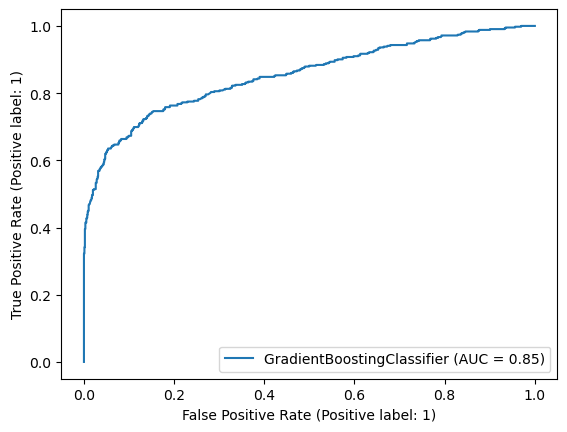

In [26]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(model,x_test,y_test)

In [28]:
yred_bron = model.predict_proba(x_test)[::,1]
from sklearn.metrics import roc_auc_score
print("AUC",roc_auc_score(y_test,yred_bron))

AUC 0.8538708716905288


### Save Model

In [32]:
from joblib import dump
dump(model,"Bank_churn_predict_model.joblib")

['Bank_churn_predict_model.joblib']